In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import animation, rc
from IPython.display import HTML
import dedalus.public as d3
from tqdm import tqdm
import os
import json
from datetime import datetime
import logging
logger = logging.getLogger(__name__)
import argparse
import shutil
import h5py
from glob import glob
import warnings
import scipy.special as special

In [25]:
# for savefiles name
savefolder = "/Users/danny/Google Drive/My Drive/uchicago/sociohydro/2024-05-29_sociohydro2D"
shutil.rmtree(savefolder, ignore_errors=True)

# simulation parameters
L = 40
N = 64
t_stop = 100
Δt = 1e-3
dealias = 3/2
timestepper = d3.SBDF2
dtype = np.float64

# check stability criterion
Δx = L / N
if Δt * Δx**(-4) > 1/8:
    warnings.warn("von Neumann stability not satisfied")

# initial condition parameters
λ = L / 2
k = 2 * np.pi / λ
ϕA0 = 1/4
δϕA = 0.05
ϕB0 = 1/4
δϕB = 0.05

# Schelling model parameters
D = 0.1
ΓA = 1
ΓB = 1

# 2D bases
coords = d3.CartesianCoordinates('x', 'y')
dist = d3.Distributor(coords, dtype=np.float64)
xbasis = d3.RealFourier(coords['x'], N, bounds=(-L/2, L/2), dealias=dealias)
ybasis = d3.RealFourier(coords['y'], N, bounds=(-L/2, L/2), dealias=dealias)

# fields
ϕA = dist.Field(name="phiA", bases=(xbasis, ybasis))
ϕB = dist.Field(name="phiB", bases=(xbasis, ybasis))

# problem
problem = d3.IVP([ϕA, ϕB], namespace=locals())

# substitutions
grad = lambda A: d3.grad(A)

# mobilities
μA = ϕA * (1 - ϕA - ϕB)
μB = ϕB * (1 - ϕA - ϕB)

# linear utility function
kaa = 1.0
kab = 1.0
kba = 11.0
kbb = 1.0
πA = kaa * ϕA + kab * ϕB
πB = kba * ϕA + kbb * ϕB

### Schelling ####
# add equation
problem.add_equation("dt(ϕA) - D*lap(ϕA) = D * (-ϕB * lap(ϕA) + ϕA * lap(ϕB)) - trace(grad(μA * grad(πA) + ΓA * μA * grad(lap(ϕA))))")
problem.add_equation("dt(ϕB) - D*lap(ϕB) = D * (-ϕA * lap(ϕB) + ϕB * lap(ϕA)) - trace(grad(μB * grad(πB) + ΓB * μB * grad(lap(ϕB))))")
# problem.add_equation("dt(ϕA) - D*lap(ϕA) = -grad(ϕA) @ grad(πA) - ϕA * lap(πA) - ΓA * (grad(ϕA) @ grad(lap(ϕA)) + ϕA * lap(lap(ϕA)))")
# problem.add_equation("dt(ϕB) - D*lap(ϕB) = -grad(ϕB) @ grad(πB) - ϕB * lap(πB) - ΓB * (grad(ϕB) @ grad(lap(ϕB)) + ϕB * lap(lap(ϕB)))")
#################

# solver and stopping
solver = problem.build_solver(timestepper)
solver.stop_sim_time = t_stop

# initial condition
x = dist.local_grid(xbasis)
y = dist.local_grid(ybasis)
ϕA.fill_random('g', distribution='normal', scale=1e-2)
ϕA["g"] += ϕA0
# ϕA["g"] = np.zeros((N, N))
# ϕA["g"][N//2, N//2] = 1.0
ϕB.fill_random('g', distribution='normal', scale=1e-2)
ϕB["g"] += ϕB0
# ϕB["g"] = np.zeros((N, N))
# ϕB["g"][N//2, N//2] = 1.0

# storage
snapshots = solver.evaluator.add_file_handler(savefolder,
                                              sim_dt=1.0,
                                              max_writes=500)
snapshots.add_task(ϕA, layout="g", name="phiA")
snapshots.add_task(ϕB, layout="g", name="phiB")

# ϕA_list = []
# ϕB_list = []
# t_list = []

# main loop
try:
    logger.info('Starting main loop...')
    while solver.proceed:
        solver.step(Δt)
        # nan check
        if np.isnan(np.min(ϕA["g"])) or np.isnan(np.min(ϕB["g"])):
                raise RuntimeError("got NaNs. Ending main loop.")
        # progress logger
        if solver.iteration % 10000 == 0:
            time_spent = solver.get_wall_time() - solver.start_time
            logger.info(rf"Iteration={solver.iteration}, sim time={solver.sim_time:0.2f} / {t_stop}, real Δt ={time_spent:0.2f} s")
except:
    logger.error("Exception raised, ending main loop.")
    raise
finally:
    solver.log_stats()

2024-05-29 18:13:42,815 subsystems 0/1 INFO :: Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 0s, Rate: 8.6e+01/s
2024-05-29 18:13:42,843 subsystems 0/1 INFO :: Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 0s, Rate: 1.0e+02/s
2024-05-29 18:13:42,879 subsystems 0/1 INFO :: Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+02/s
2024-05-29 18:13:42,911 subsystems 0/1 INFO :: Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+02/s
2024-05-29 18:13:42,945 subsystems 0/1 INFO :: Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+02/s
2024-05-29 18:13:42,977 subsystems 0/1 INFO :: Building subproblem matrices 20/32 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+02/s
2024-05-29 18:13:43,009 subsystems 0/1 INFO :: Building subproblem matrices 24/32 (~75%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+02/s
2024-05-29 18:13:43,040 subsystems 0/1 INFO :: Building subproblem matric

RuntimeError: got NaNs. Ending main loop.

In [26]:
files = sorted(glob(os.path.join(savefolder, "*h5")))
for file in files:
    with h5py.File(file, "r") as d:
        x = d['tasks']['phiA'].dims[1][0][()]
        y = d['tasks']['phiA'].dims[2][0][()]
        t = d['tasks']['phiA'].dims[0]["sim_time"][()]
        ϕA = d['tasks']['phiA'][()]
        ϕB = d['tasks']['phiB'][()]

2024-05-29 18:16:23,307 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2024-05-29 18:16:23,309 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 864x432 -pix_fmt rgba -r 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /var/folders/n8/skcq750x2vdc2nch0nv470wh0000gn/T/tmp6ba4ail2/temp.m4v


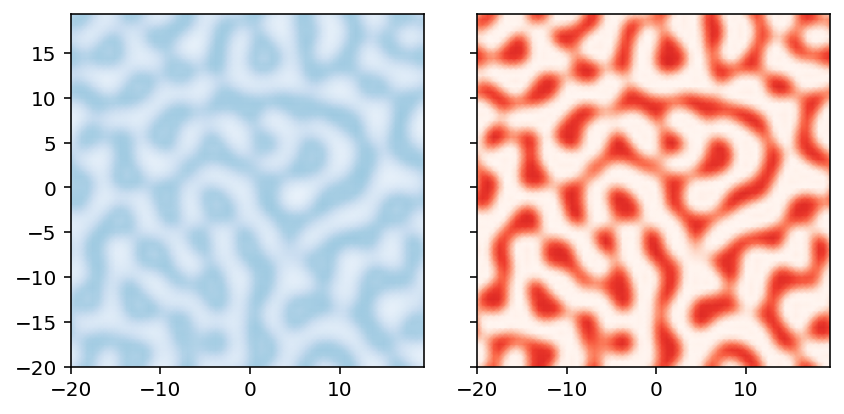

In [27]:
fig, ax = plt.subplots(1, 2, dpi=144, figsize=(6, 3), sharey=True)
ax[0].set_aspect(1)
ax[1].set_aspect(1)
plt.tight_layout()

# initialize line
cA = ax[0].pcolormesh(x, y, ϕA[0], cmap="Blues",
                  vmin=0, vmax=1, rasterized=True, shading="gouraud")
cB = ax[1].pcolormesh(x, y, ϕB[0], cmap="Reds",
                  vmin=0, vmax=1, rasterized=True, shading="gouraud")
# cax = ax.inset_axes([1.05, 0.0, 0.05, 1])
# fig.colorbar(c, ax=ax, cax=cax)

def animate(i):
    cA.set_array(ϕA[i].flatten())
    cB.set_array(ϕB[i].flatten())

    return [cA, cB]

anim = animation.FuncAnimation(fig, animate, frames=len(ϕA),
                               interval=40, blit=True)
# anim.save("/Users/danny/Google Drive/My Drive/uchicago/sociohydro/2023-12-01_2DdedalusSim.mp4")

HTML(anim.to_html5_video())


In [31]:
ϕB.min()

-0.07482471511629216